In [1]:
import pickle
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, RandomSampler, WeightedRandomSampler
from focal_loss.focal_loss import FocalLoss
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
import os
#from autoencoder_utils import *
from autoencoder_utils import *
#from utils import *
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Filepath to embeddings
fname = "/mnt/mimic/data/HAIM/mimic_extras/embeddings.csv"

# YES-TOKEN: 3276
# NO-TOKEN: 956

### Get projection-model and data

In [18]:
proj_model = torch.load('results/vd/autoencoder2/model.pth').to('cuda')
proj_model.eval()

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=1024, out_features=2048, bias=True)
    (1): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=2048, out_features=1024, bias=True)
    (1): ReLU()
  )
)

In [3]:
df = pd.read_csv(fname)

Data = DataSplit(df)
Data.split_data('mortality')

X,V,T = Data.get_type('vmd_')

x_test = T.values.tolist()
labels = Data.y_test.tolist()

/home/liv/multimodal_healthcare/autoencoder_utils.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_death_small48['y'] = 1
/home/liv/multimodal_healthcare/autoencoder_utils.py:92: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_alive_big48['y'] = 0
/home/liv/multimodal_healthcare/autoencoder_utils.py:93: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pand

### Train Classifier on projections

In [19]:
# Since the classes are very imbalanced, we weigh the classes to increase performance
w0 = len(Data.y_train)/(2*sum(Data.y_train == 0))
w1 = len(Data.y_train)/(2*sum(Data.y_train == 1))
weights = torch.tensor([w0, w1], dtype = torch.float).to("cuda")

class_sample_count = np.array([len(np.where(Data.y_train == t)[0]) for t in np.unique(Data.y_train)])
weight = 1. / class_sample_count
samples_weight = np.array([weight[t] for t in Data.y_train])

samples_weight = torch.from_numpy(samples_weight)
samples_weight = samples_weight.double()

torch.manual_seed(42)

#sampler = WeightedRandomSampler(samples_weight, len(samples_weight))

train_set = CustomDataset(X.values.tolist(), Data.y_train.tolist())
val_set = CustomDataset(V.values.tolist(), Data.y_validation.tolist())

sampler = RandomSampler(train_set, replacement=False)

train_loader = DataLoader(train_set, batch_size=32, sampler=sampler, num_workers=5)
val_loader = DataLoader(val_set, batch_size=32, num_workers=5)



# Setting model and hyperparameters
clf_head = ClfHead3()
#optimizer = optim.Adam(proj_model.parameters(), lr=0.0003, weight_decay=0.00003) #0.00003
clf_optimizer = optim.Adam(clf_head.parameters(), lr=0.0003, weight_decay=0.00003)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=clf_optimizer, patience=7)
#loss_fn = nn.CrossEntropyLoss()
loss_fn = nn.CrossEntropyLoss(weights)

num_epochs = 50

# Run training
fine_tuned, train_losses, train_accs, val_losses, val_accs = training_loop_clf(proj_model, clf_head, clf_optimizer, loss_fn, train_loader, val_loader, num_epochs, scheduler)

Starting training
Epoch 1/50: Train loss: 0.647, Train acc.: 0.974, Val. loss: 0.449, Val. acc.: 0.973
Epoch 2/50: Train loss: 0.634, Train acc.: 0.972, Val. loss: 0.462, Val. acc.: 0.970
Epoch 3/50: Train loss: 0.635, Train acc.: 0.967, Val. loss: 0.504, Val. acc.: 0.970
Epoch 4/50: Train loss: 0.627, Train acc.: 0.968, Val. loss: 0.511, Val. acc.: 0.966
Epoch 5/50: Train loss: 0.622, Train acc.: 0.968, Val. loss: 0.447, Val. acc.: 0.971
Epoch 6/50: Train loss: 0.615, Train acc.: 0.967, Val. loss: 0.391, Val. acc.: 0.971
Epoch 7/50: Train loss: 0.612, Train acc.: 0.965, Val. loss: 0.404, Val. acc.: 0.970
Epoch 8/50: Train loss: 0.612, Train acc.: 0.966, Val. loss: 0.488, Val. acc.: 0.967
Epoch 9/50: Train loss: 0.608, Train acc.: 0.965, Val. loss: 0.496, Val. acc.: 0.956
Epoch 10/50: Train loss: 0.598, Train acc.: 0.962, Val. loss: 0.374, Val. acc.: 0.964
Epoch 11/50: Train loss: 0.585, Train acc.: 0.961, Val. loss: 0.482, Val. acc.: 0.960
Epoch 12/50: Train loss: 0.584, Train acc.: 0

In [20]:
preds = []

for i, item in enumerate(x_test):
    inputs = torch.tensor(item, dtype=torch.float32).unsqueeze(0).to('cuda')
    enc = proj_model.encoder(inputs)
    output = fine_tuned(enc)
    hard_pred = torch.argmax(output, dim=1)
    preds.append(hard_pred)

### Losses and Accuracies

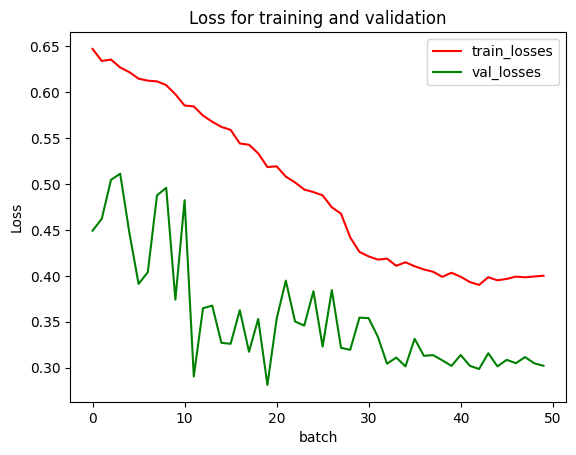

In [21]:
x = list(range(len(train_losses)))

repetitions = len(train_losses) // len(val_losses)
extended_val_loss = [element for element in val_losses for _ in range(repetitions)]

remaining_elements = len(train_losses) % len(val_losses)
if remaining_elements > 0:
    extended_val_loss += val_losses[:remaining_elements]

plt.plot(x, train_losses, color='r', label='train_losses')
plt.plot(x, extended_val_loss, color='g', label='val_losses')

plt.title('Loss for training and validation')
plt.ylabel('Loss')
plt.xlabel('batch')

plt.legend()

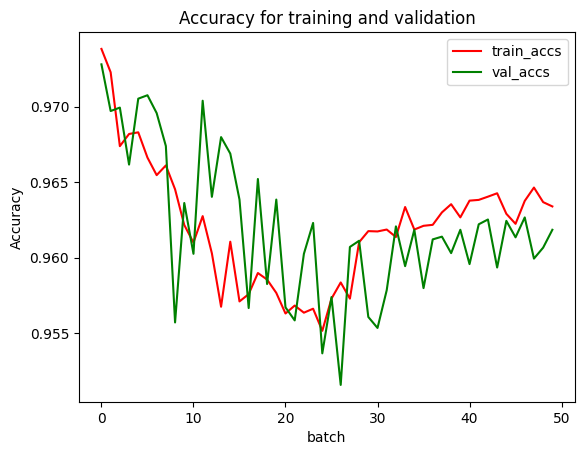

In [22]:
x = list(range(len(train_accs)))

repetitions = len(train_accs) // len(val_accs)
extended_val_accs = [element for element in val_accs for _ in range(repetitions)]

remaining_elements = len(train_accs) % len(val_accs)
if remaining_elements > 0:
    extended_val_accs += val_accs[:remaining_elements]

plt.plot(x, train_accs, color='r', label='train_accs')
plt.plot(x, extended_val_accs, color='g', label='val_accs')

plt.title('Accuracy for training and validation')
plt.ylabel('Accuracy')
plt.xlabel('batch')

plt.legend()

### Confusion Matrix

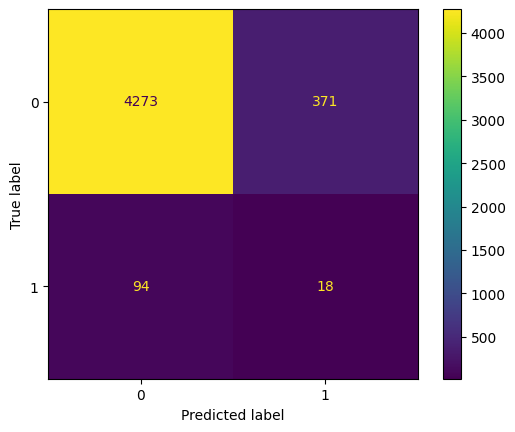

In [23]:
numpy_arrays = [t.cpu().numpy() for t in preds]
preds = np.array(numpy_arrays)

conf_matrix = metrics.confusion_matrix(labels, preds)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()

### F1-score and AUC

In [24]:
f1 = metrics.f1_score(labels, preds)
auc = metrics.roc_auc_score(labels, preds)
print('f1: ', f1)
print('auc: ', auc)

f1:  0.0718562874251497
auc:  0.5404131290759198


### Precision, Recall and Accuracy

In [26]:
precision = metrics.precision_score(labels, preds)
recall = metrics.recall_score(labels, preds)
accuracy = metrics.accuracy_score(labels, preds)
print('precision: ', precision)
print('recall: ', recall)
print('accuracy: ', accuracy)

precision:  0.04627249357326478
recall:  0.16071428571428573
accuracy:  0.902228763666947


### ROC-curve, FPR and TPR thresholds

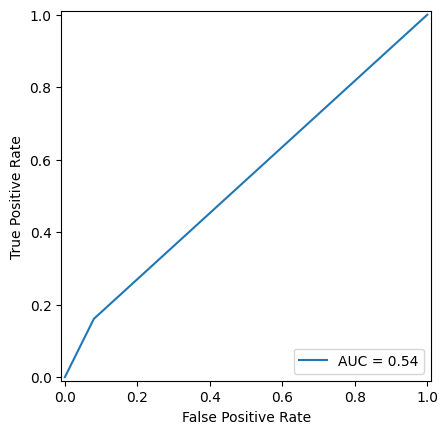

In [27]:
fpr, tpr, thresholds = metrics.roc_curve(labels, preds)
roc_auc = metrics.auc(fpr, tpr)
display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)

display.plot()

### Visualize representations in autoencoder

In [28]:
proj_model.eval()

reconstructions = []
all_inp = []
encoded = []

for i, item in enumerate(x_test):
    inputs = torch.tensor(item, dtype=torch.float32).unsqueeze(0).to('cuda')
    with torch.no_grad():
        reconstructed = proj_model(inputs)
        reconstructions.append(reconstructed)
        encoded_embeddings = proj_model.encoder(inputs)
        all_inp.append(inputs)
        encoded.append(encoded_embeddings)

numpy_arrays = [t.cpu().numpy() for t in reconstructions]
reconstructions = np.array(numpy_arrays)
numpy_arrays = [t.cpu().numpy() for t in all_inp]
inputs = np.array(numpy_arrays)
numpy_arrays = [t.cpu().numpy() for t in encoded]
encoded = np.array(numpy_arrays)

ValueError: cannot reshape array of size 1024 into shape (10,11)

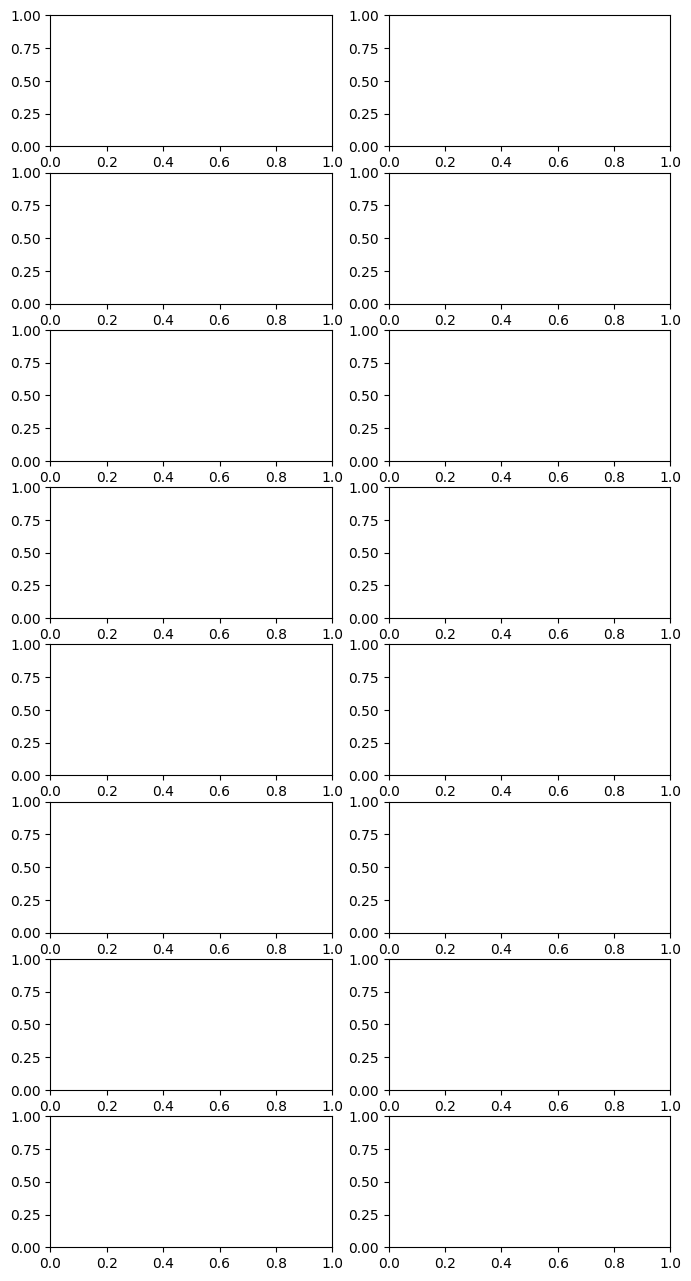

In [29]:
num_samples = min(8, len(inputs))
fig, axes = plt.subplots(num_samples, 2, figsize=(8, 2*num_samples))
for i in range(num_samples):
    # Plot original input
    axes[i, 0].imshow(inputs[i].reshape(10, 11), cmap='gray')
    axes[i, 0].set_title('Original')
    axes[i, 0].axis('off')
    
    # Plot reconstruction
    axes[i, 1].imshow(reconstructions[i].reshape(10, 11), cmap='gray')
    axes[i, 1].set_title('Reconstruction')
    axes[i, 1].axis('off')

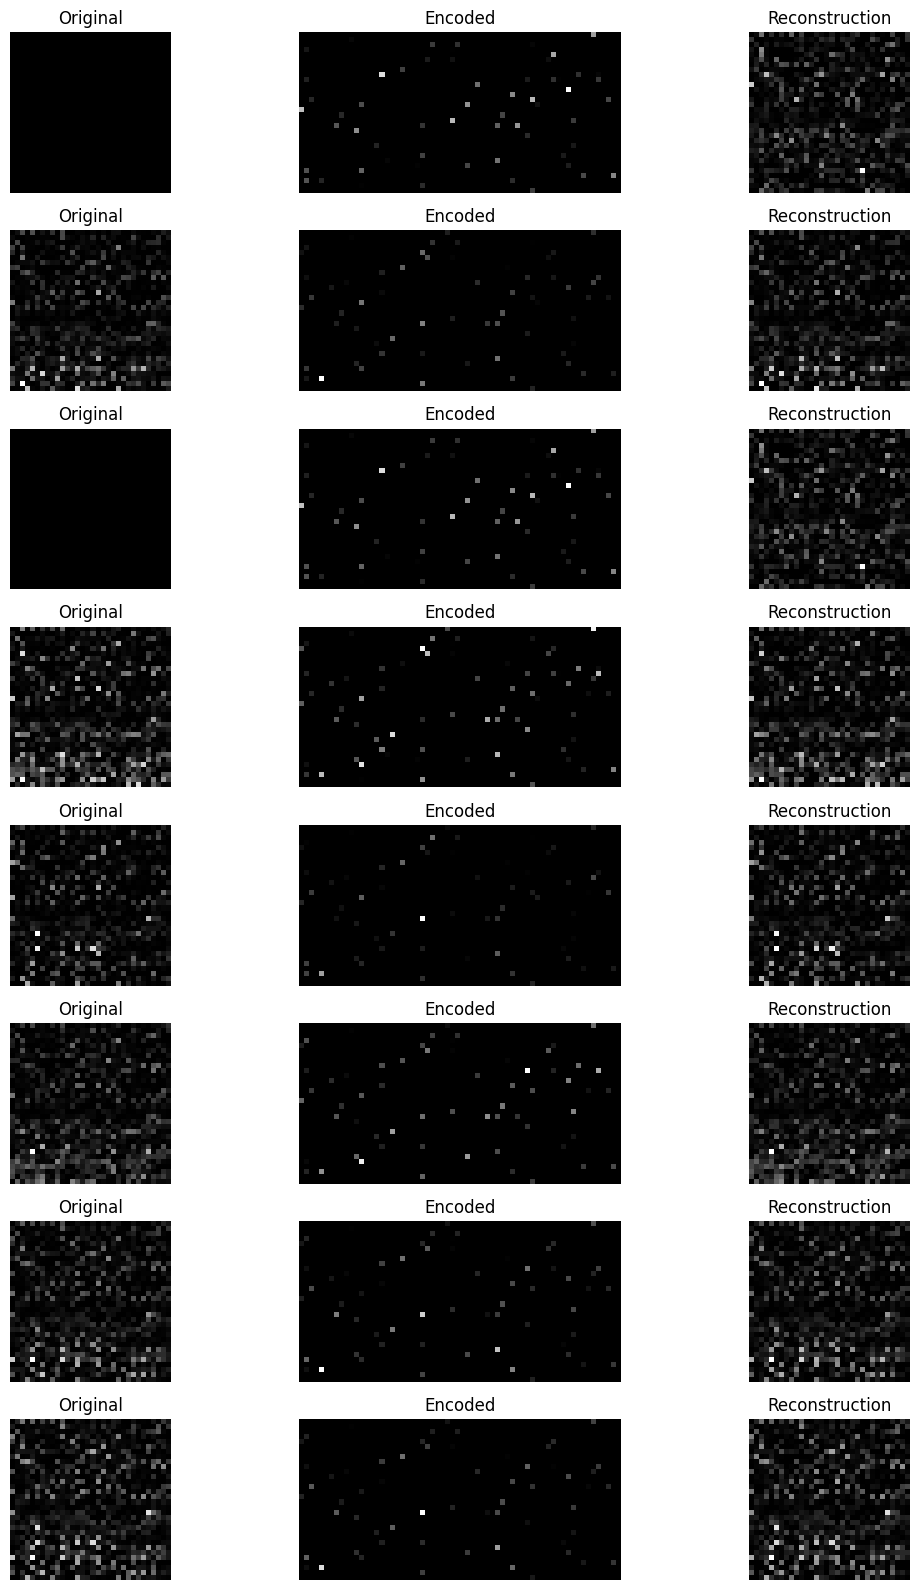

In [31]:
num_samples = min(8, len(inputs))
fig, axes = plt.subplots(num_samples, 3, figsize=(12, 2*num_samples))
for i in range(num_samples):
    # Plot original input
    axes[i, 0].imshow(inputs[i].reshape(32, 32), cmap='gray')
    axes[i, 0].set_title('Original')
    axes[i, 0].axis('off')
    
    # Plot encoded embedding
    axes[i, 1].imshow(encoded[i].reshape(32, 64), cmap='gray')
    axes[i, 1].set_title('Encoded')
    axes[i, 1].axis('off')

    # Plot reconstruction
    axes[i, 2].imshow(reconstructions[i].reshape(32, 32), cmap='gray')
    axes[i, 2].set_title('Reconstruction')
    axes[i, 2].axis('off')
    

plt.tight_layout()
plt.show()